In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)



In [2]:
houses.columns

Index(['median_house_value', 'median_income', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude',
       'longitude'],
      dtype='object')

## Data Preparation

### Feature Selection
- I completed feature selection to explore the dataset and discover which features would be most useful for learning

#### Generating Correlation Matrix
- I genereated this to see the correlation between the features in the dataset
- This will help me to infer which features might contribute the most/least to a model and could be removed for dimensionality reduction


Text(0.5, 1.0, 'A heatmap to show the correlation between all features in dataset')

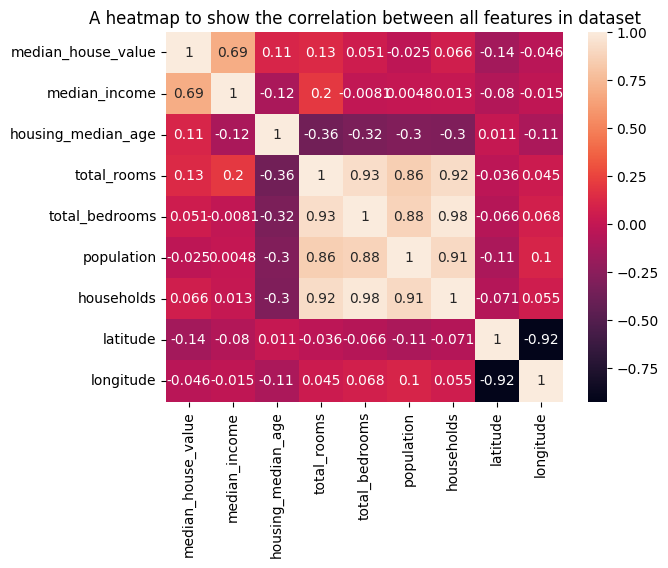

In [3]:
# Generating correlation matrix
corr_matrix = houses.corr()


# Generatig heatmap with seaborn
heatmap_all_features = sns.heatmap(corr_matrix, annot=True)
heatmap_all_features.set_title('A heatmap to show the correlation between all features in dataset')

Text(0.5, 1.0, 'A heatmap to show the feature pairs with highest correlations')

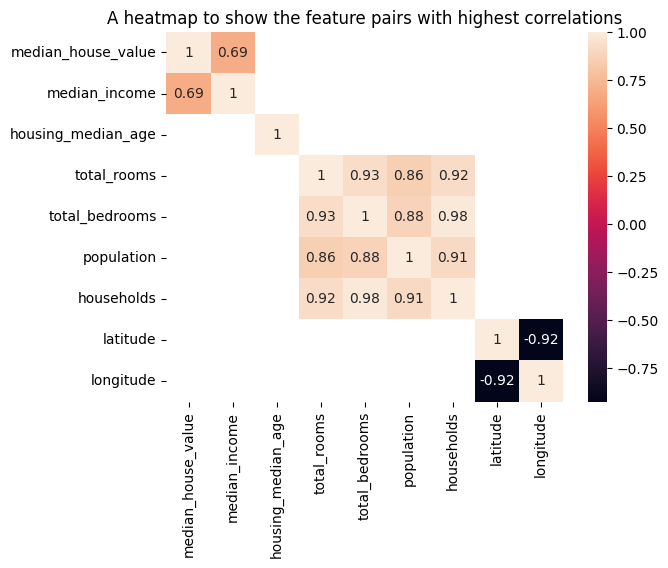

In [4]:
# Defining mask to apply to heatmap only showing highest correlations
mask = np.logical_or(corr_matrix > 0.5, corr_matrix < -0.5)

heatmap_high_corr_features = sns.heatmap(corr_matrix[mask], annot=True)

heatmap_high_corr_features.set_title('A heatmap to show the feature pairs with highest correlations')

### Generating Correlation Matrix - Results
- The results showed only 1 feature with a high correlation with 'median_house_value' that being 'median_income' with a correlation of '0.69'
- There are also 3 features 'total_rooms', 'total_bedrooms', 'population' that have very high correlations with other features in the dataset
    - Using some domain context, the high correlations are expected as they concern how many rooms are in a house and how many bedrooms/population which logically, would positivelty correlate
    - Because of this, some of these features could be removed in the future to reduce the complexity of the model and possibly improve its performance
- I'm deciding to keep all of the features for now, but will try removing features that might be Multicolinnear to improve model performance

### Anomaly Detect/ Removal

### Plotting Anomalies
- I did this to see which features had anomalies (if any) in them so I can focus on removing them specifically

plotting columns ['median_house_value', 'median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude']
grid is 3x4
[[<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]]
column median_house_value
plotting on axes [0,0]
column median_income
plotting on axes [0,1]
column housing_median_age
plotting on axes [0,2]
column total_rooms
plotting on axes [0,3]
column total_bedrooms
plotting on axes [1,0]
column population
plotting on axes [1,1]
column households
plotting on axes [1,2]
column latitude
plotting on axes [1,3]
column longitude
plotting on axes [2,0]


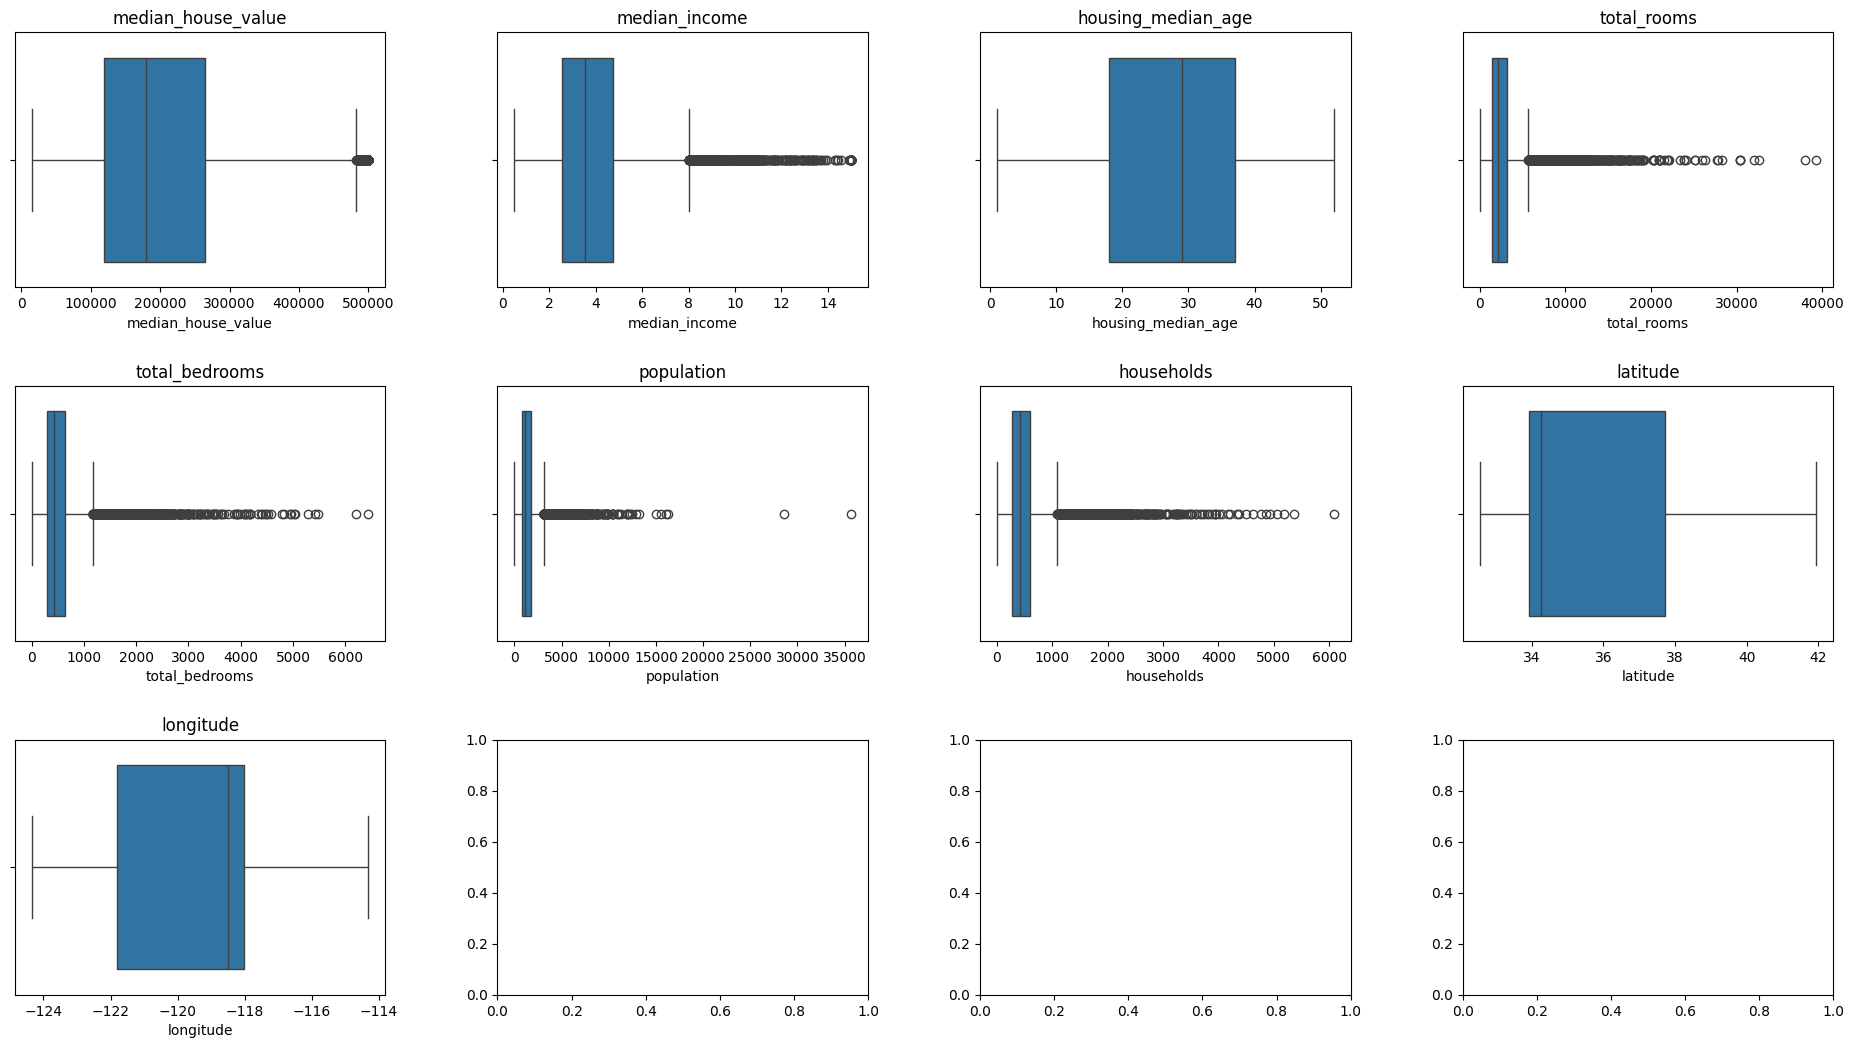

In [5]:
### PaoloMissier - https://github.com/PaoloMissier/CSC3831-2021-22/blob/main/ASSESSED-COURSEWORK/Anomaly_detection_coursework_starter.ipynb
from math import ceil

def plot_distributions(data, columns, type='boxplot', title=None):

    print("plotting columns {c}".format(c=list(columns)))
    
    if type not in {'boxplot', 'dkeplot'}:
        print("type= {boxplot, dkeplot} only are supported")
        return

    ## grid size depends on number of columns
    ## max 4 columns in the grid
    maxCols  = 4
    
    if len(columns) < 4:
        numCols = len(columns)
    else:
        numCols = maxCols
    numRows = ceil(len(columns) / 4)
    
    print("grid is {0}x{1}".format(numRows, numCols))

    fig, axs = plt.subplots(numRows, numCols)
    fig.suptitle(title)
    fig.set_figwidth(5*numCols)
    fig.set_figheight(3*numCols)
    fig.tight_layout(pad=5.0)

    print(axs)

#         handle special axes
    if numRows == 1 and numCols == 1:
        c = columns[0]
        # axes is a scalar
        if type == 'boxplot':
            sns.boxplot(data=data, x=c, ax=axs)
        else:
            sns.kdeplot(data=data, x=c, ax=axs)
        axs.set_title(c)

    elif numRows == 1:
        i = 0
        # axes is a 1D array
        for c in columns:
#         print("column {c}".format(c=c))
            if type == 'boxplot':
                sns.boxplot(data=data, x=c, ax=axs[i])
            else:
                sns.kdeplot(data=data, x=c, ax=axs[i])
            axs[i].set_title(c)
            i = i+1
        
    else:
    # general case of a 2D grid    
        i=j=0    
        for c in columns:
            print("column {c}".format(c=c))
            if type == 'boxplot':
                print("plotting on axes [{0},{1}]".format(i,j))
                sns.boxplot(data=data, x=c, ax=axs[i,j])
            else:
                sns.kdeplot(data=data, x=c, ax=axs[i,j])

            axs[i,j].set_title(c)
            j = j+1
            if j == 4:
                i = i+1
                j= 0

plot_distributions(houses, houses.columns)

### Plotting Anomalies - Results

- Can clearly see several features with outliers in them including...

    - median house value
    - median income
    - total rooms
    - total bedrooms
    - population
    - households

### Oultier Removeal
- This will remove outliers and improve the performance of models that are sensitive to outliers, which regression models often are.

In [6]:
from sklearn.neighbors import LocalOutlierFactor

# Defining new LOF model
clf=LocalOutlierFactor(n_neighbors=3)
clf.fit(houses)

predicted_outliers = clf.fit_predict(houses)

# Creating new 'LOF' column with negative outlier factor values
results = clf.negative_outlier_factor_

houses['LOF'] = results.tolist()
houses = houses.query('LOF > -1.25')
houses = houses.drop(['LOF'],axis=1)

### Feature Normalisation
- I do feature scaling in order to reduce the variance of each of the features
- This is because many ML models are sensitive to the scale of features
- Chose to normalise using standard scaling since from EDA I saw the features all have a Gaussian distribution and Standard Scaling works best on these types of datasets

In [7]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Select columns to scale (excluding the target variable 'median_house_value')
columns_to_scale = houses.columns[houses.columns != 'median_house_value']

# Extract the features to be scaled (X)
X = houses[columns_to_scale]

# Use the scaler to standardize the features
houses_scaled = pd.DataFrame(scaler.fit_transform(X))

# Assign column names to the scaled features DataFrame
houses_scaled.columns = columns_to_scale

# Add the 'median_house_value' column back to the scaled DataFrame
houses_scaled['median_house_value'] = houses['median_house_value'].values

# Display the scaled DataFrame
houses_scaled



,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude,median_house_value
0,2.340841,-0.625527,2.337768,1.586700,1.069766,1.914770,1.032708,-1.304509,358500.0
1,1.784186,1.848770,-0.570471,-0.879702,-0.913338,-0.906954,1.028032,-1.314477,352100.0
2,0.066983,1.848770,-0.853446,-0.817773,-0.999741,-0.859974,1.028032,-1.319460,269700.0
3,-0.134404,1.848770,-0.018980,-0.074621,-0.290820,0.082558,1.023355,-1.319460,299200.0
4,-0.976157,1.050610,-0.008652,0.399273,-0.174228,0.320394,1.023355,-1.324444,226700.0
...,...,...,...,...,...,...,...,...,...
17768,-1.253471,-0.306263,-0.468228,-0.384267,-0.550029,-0.457709,1.790319,-0.741345,78100.0
17769,-0.722144,-0.864976,-0.968082,-0.987405,-1.059078,-1.091936,1.794996,-0.801150,77100.0
17770,-1.178984,-0.944792,-0.164082,-0.085391,-0.381387,-0.155277,1.766936,-0.806134,92300.0
17771,-1.089834,-0.864976,-0.367534,-0.290027,-0.658293,-0.401921,1.766936,-0.855972,84700.0


## Train, Validate, Test Splot

- Used a 70/15/15 split for Training, Testing and Validation respectively
    - I did this as the dataset is large and a substantial amount of data can be delegated for both training and evaluation using this split
- I decided to use every feature in the split as when testing using a subset of features, the model performance dropped.
- I set a fixed random seed (42) to ensure rthe same split can be recreated, facilitating consistent model evaluation


In [8]:
from sklearn.model_selection import train_test_split

# Set a random seed for reproducibility
seed = 42

# Extract features (X) and target variable (y) from the scaled DataFrame
X = houses_scaled.drop('median_house_value', axis=1)
y = houses_scaled['median_house_value']

# Split the dataset into Training and Testing split
# The test set will be 30% of the entire dataset
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Split the temporary set into Validation (50%) and final test (50%)
# The validation set will be 15% of the entire dataset, and the final test set will be 15%
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=seed)

## Metric Selection

<strong>MAE,RMSE,R^2, K-fold cross validation</strong>

- These 4 metrics are often used to evaluate the performance of regression models.

<br>
<strong>MAE</strong>
<br>
- Shows the average absolute difference between the 
predicted label value and the actual label value
- Lower values indicates better model performance
<br>
<strong>RMSE/MSE</strong>
<br>
- Shows the average square difference between predicted labels and actual labels and finds the square root making it interpretable in its original units
- Included as it penalises large errors in the models's preidctions
- RMSE is there
- Lower values indicate better model performance
<br>
<strong>R^2</strong>
<br>
- Shows how well the model fits the data
- Higher values (between 0 and 1) indicate better model performance

## Model 1 - Ridge Regression

https://corporatefinanceinstitute.com/resources/data-science/ridge/



- Chose Ridge Regression as it works well on datasets with multicollinearity like my dataset.
- This is a better alternative than removing features as I can still predict my target feature without reducing the already small number of features.

### Defining Ridge Model and Finding Optimum Alpha Value
- Completed grid search to look for the optimum Alpha value to ensure the model works as effectively as possible to predict target

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Create a Ridge Regression model
m1 = Ridge()

# Define the hyperparameter grid to search
param_grid = {'alpha': [0.1, 0.01, 0.05, 100.0, 10]}

# Create a GridSearchCV object with Ridge Regression, hyperparameter grid, 5-fold cross-validation, and R-squared scoring
grid_search = GridSearchCV(m1, param_grid, cv=5, scoring="r2")

# Fit the model to the training data using grid search
grid_search.fit(X_train_temp, y_train_temp)

# Get the best hyperparameters based on cross-validated R-squared score
best_params = grid_search.best_params_

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'alpha': 0.1}


### Getting R^2 Value For Validation and Test Dataset
- I did this to ensure that my data generalises well to new, unseeen data and to attemot to improve R^2 value before applying model to the final test set

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

# Create a Ridge Regression model with the best hyperparameters from the grid search
m1 = Ridge(**best_params)

# Fit the model to the training data
m1.fit(X_train_temp, y_train_temp)

# Make predictions on the validation set
y_val_pred = m1.predict(X_val)

# Calculate R-squared score on the validation set
val_r2 = r2_score(y_val, y_val_pred)

# Print the validation R-squared score
print("Validation R-squared Ridge Regression:", val_r2)

Validation R-squared Ridge Regression: 0.6795087443223654


### Model Coefficient Analysis
- I plotted did this to see which features are contributing the most/ least to the model possibly allowing me to remove useless features

C:\Users\Temp\AppData\Local\Temp\ipykernel_20468\3605696184.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  model_coefs_barplot = sns.barplot(x=X, y=y, palette='viridis')


Text(0.5, 1.0, 'A barplot to show features and their feature coefficients')

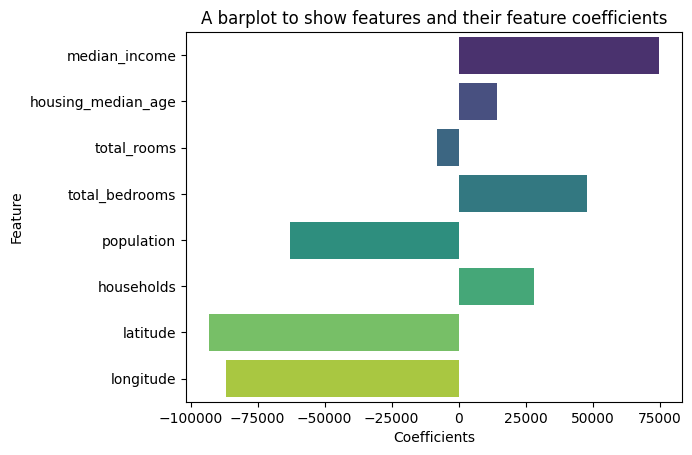

In [11]:
# Create a DataFrame to store feature names and their corresponding coefficients
model_coefs = pd.DataFrame({'Feature': X_train.columns, 'Coefficients': m1.coef_})

# Extract the coefficients and feature names for plotting
X = model_coefs['Coefficients']
y = model_coefs['Feature']

# Create a barplot using seaborn to visualize feature coefficients
model_coefs_barplot = sns.barplot(x=X, y=y, palette='viridis')

# Set the title for the barplot
model_coefs_barplot.set_title('A barplot to show features and their feature coefficients')

### Model Coefficient Analysis - Results
- From this analysis, I saw 'housesholds','housing_median_age' and 'total_rooms' having the smallest values for coefficients
- This showed me they contributed the least to the model
- Referring back to my correlation matrix heatmap, I can see that 'houseing_median_age' has no 'high' correlations with any other features so I'm going to remove it to see if the model's performance improves

### Removing 'housing_median_age' and testing model again

In [12]:
# Create a Ridge Regression model with the best hyperparameters from the grid search
m1 = Ridge(**best_params)

# Fit the model to the training data, excluding the 'housing_median_age' feature
m1.fit(X_train_temp.drop(['housing_median_age'], axis=1), y_train_temp)

# Make predictions on the validation set, excluding the 'housing_median_age' feature
y_val_pred = m1.predict(X_val.drop(['housing_median_age'], axis=1))

# Print the predicted values on the validation set
print(y_val_pred)

# Calculate R-squared score on the validation set
val_r2 = r2_score(y_val, y_val_pred)

# Print the validation R-squared score
print("Validation R-squared Ridge Regression (excluding 'housing_median_age'):", val_r2)

[286162.85814021 185447.0739028  279179.0974506  ... 113431.27275026
 127450.9136146  285446.9819911 ]
Validation R-squared Ridge Regression (excluding 'housing_median_age'): 0.6656658963585211


### Removing 'housing_median_age' and testing model again - Results

- This resulted in a slighlty lower R^2 value (0.61 compared to 0.62) than before, so I'm going to keep the feautes

### Performing K-Fold Cross Validation
- I did this to get a more accurate score for R^2

In [13]:
# Importing necessary modules from scikit-learn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

# Creating an instance of Ridge regression with the best hyperparameters obtained from the grid search
m1 = Ridge(**best_params)

# Fitting the Ridge regression model to the training data
m1.fit(X_train_temp, y_train_temp)

# Setting up a KFold cross-validation with 5 folds, shuffling the data, and setting a random seed for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Performing cross-validation and obtaining R-squared scores
cv_scores_r2 = cross_val_score(m1, X_test, y_test, cv=kf, scoring='r2')

# Printing the average R-squared score after completing cross-validation
print(f'The average R-squared score after completing cross-validation was: {cv_scores_r2.mean()}')

The average R-squared score after completing cross-validation was: 0.6575674185166698


In [14]:
# Make predictions on the test set using the trained Ridge Regression model
y_test_pred = m1.predict(X_test)

# Calculate R-squared score on the test set
test_r2 = r2_score(y_test, y_test_pred)

# Print the test R-squared score
print("Test R-squared Ridge Regression:", test_r2)

Test R-squared Ridge Regression: 0.6583806866589442


### Comments

- The model produced an r^2 score of 0.64(2sf) which can be considered a moderate level of predictability
- This shows that the chosen independent variables contribute meaningfully to the model and the moedel can predict the target variable moderately well.

## Model 2 - Gradient Boosting Regression

- Chose Gradient Boosting Reggression for my second model
- I did this as the model works by combining weak learners that give importance to features that contribute most to prediction which mau improve R^2

### Defining Gradient Boosting Model and performing Grid Search

In [15]:
# Importing the GradientBoostingRegressor and GridSearchCV from scikit-learn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Creating an instance of the GradientBoostingRegressor
m2 = GradientBoostingRegressor()

# Defining the hyperparameter grid to search through
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Creating an instance of GridSearchCV with the GradientBoostingRegressor, hyperparameter grid, scoring metric, and cross-validation settings
grid_search = GridSearchCV(m2, param_grid, scoring='r2', cv=5, n_jobs=-1)

# Fitting the GridSearchCV to the training data
grid_search.fit(X_train_temp, y_train_temp)

# Retrieving the best estimator and best parameters from the grid search
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

# Printing the best estimator and best parameters
print("Best Estimator:", best_estimator)
print("Best Parameters:", best_params)

Best Estimator: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=150)
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}


### Getting R^2 Value For Validation and Test Dataset

In [16]:
# Creating a new instance of GradientBoostingRegressor with the best hyperparameters obtained from the grid search
m2 = GradientBoostingRegressor(**best_params)

# Fitting the model to the training data
m2.fit(X_train_temp, y_train_temp)

# Making predictions on the validation set
y_val_pred = m2.predict(X_val)

# Calculating the R-squared score on the validation set
val_r2 = r2_score(y_val, y_val_pred)

# Printing the R-squared score on the validation set
print("Validation R-squared Ridge Regression:", val_r2)

Validation R-squared Ridge Regression: 0.9308405803011917


In [17]:
# Making predictions on the test set using the trained GradientBoostingRegressor model
y_test_pred = m2.predict(X_test)

# Calculating the R-squared score on the test set
test_r2 = r2_score(y_test, y_test_pred)

# Printing the R-squared score on the test set
print("Test R-squared Ridge Regression:", test_r2)

Test R-squared Ridge Regression: 0.8317458899695389


### Getting R^2 Value For Validation and Test Dataset - Results

Validation
- This validation gave a very high R^2 score of 0.92(2sf)
- This is shows the model can generalise well to a new unseen dataset and I'm unlikely to have to attempt to improve the model

Test
- The model performed slighly worse onn the test test getting an R^2 score of 0.82(2s.f)
- This is still a very high R^2 value and shows the model can generalise well to new data and has strong predicting power.

### Performing K-Fold Cross Validation

In [18]:
# Setting up a KFold cross-validation with 5 folds, shuffling the data, and setting a random seed for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Performing cross-validation using the trained GradientBoostingRegressor model (m2) on the test set
cv_scores_r2 = cross_val_score(m2, X_test, y_test, cv=kf, scoring='r2')

# Printing the average R-squared score after completing cross-validation
print(f'The average R-squared score after completing cross-validation was: {cv_scores_r2.mean()}')

The average R-squared score after completing cross-validation was: 0.8017722716567285


### Performing K-Fold Cross Validation - Results

- After performing cross validation and getting an average of the R^2 scores, the model yielded a score of 0.80(2sf)
- Although slightly lower than the the score of the validation and test set , it is still a very high R^2 score and shows the model, on average has strong predicting power.

### Comments

- The model produced an r^2 score of 0.81(2sf) which can be considered a highlevel of predictability
- This shows that the chosen independent variables contribute meaningfully to the model and the moedel can predict the target variable very well.

## Model 3 - Linear Regression (vanilla)

- Although this is the most basic of all the models, I still thought it important to use it as it is so popular and widely used


### Defining Linear Regression model and testing on validation and testing sets

In [19]:
# Importing the LinearRegression model from scikit-learn
from sklearn.linear_model import LinearRegression

# Creating an instance of the LinearRegression model
m3 = LinearRegression()

# Fitting the LinearRegression model to the training data
m3.fit(X_train_temp, y_train_temp)

# Making predictions on the validation set
y_val_pred = m3.predict(X_val)

# Calculating the R-squared score on the validation set
val_r2 = r2_score(y_val, y_val_pred)

# Printing the R-squared score on the validation set
print("Validation R-squared Linear Regression:", val_r2)

Validation R-squared Linear Regression: 0.6795080079557849


In [20]:
# Making predictions on the test set using the trained LinearRegression model (m3)
y_test_pred = m3.predict(X_test)

# Calculating the R-squared score on the test set
test_r2 = r2_score(y_test, y_test_pred)

# Printing the R-squared score on the test set
print("Test R-squared Linear Regression:", test_r2)

Test R-squared Linear Regression: 0.6583793669310443


### Defining Linear Regression model and testing on validation and testing sets - Results

- The results gave R^2 values that inferred the model having moderate predicting power (0.62 - Val , 0.64 - Test)
- This shows that the chosen independent variables contribute meaningfully to the model and the moedel can predict the target variable moderately well.

## Model Comparison

### R^2 Score Comparison


In [21]:
# List of models to evaluate
MODELS = [m1, m2, m3]

# Function to return an array of R-squared scores for each model on the test set
def return_r2_array(models):
    # Array to store R-squared scores for each model
    r2_array = []

    # Loop through each model in the list
    for model in models:
        # Make predictions on the test set using the current model
        y_test_pred = model.predict(X_test)

        # Calculate the R-squared score on the test set
        test_r2 = r2_score(y_test, y_test_pred)

        # Append the R-squared score to the array
        r2_array.append(test_r2)

    # Return the array of R-squared scores
    return r2_array

In [22]:
# Creating a DataFrame to store R-squared scores for each model
rsquare_score_dataframe = pd.DataFrame({
    'R^2': return_r2_array(MODELS),
    'Model': ['M1 - Ridge Regression', 'M2 - Gradient Boosting', 'M3 - Linear Regression']
})

# Displaying the DataFrame
rsquare_score_dataframe

,R^2,Model
0,0.658381,M1 - Ridge Regression
1,0.831746,M2 - Gradient Boosting
2,0.658379,M3 - Linear Regression


C:\Users\Temp\AppData\Local\Temp\ipykernel_20468\1846361845.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rsquare_score_dataframe, x='Model', y='R^2', palette='viridis')


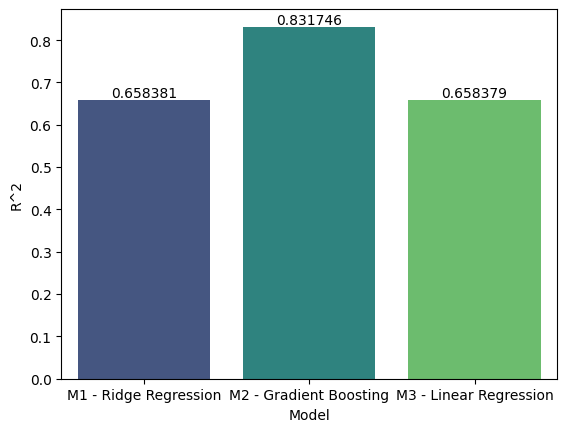

In [23]:
# Creating a bar plot using Seaborn to visualize R-squared scores for each model
ax = sns.barplot(data=rsquare_score_dataframe, x='Model', y='R^2', palette='viridis')

# Adding labels to the bars with R-squared scores
for i in ax.containers:
    ax.bar_label(i,)

# Displaying the plot


### R^2 Score Comparison - Rationale

<strong>Results</strong>

- Can clearly see that Gradient Boosting gave the largest R^2 value.
- This was followed by Ridge Regression and then Linear Regression but their scores are very close

<strong>Interpretation</strong>
- These results could be due to the iterative nature of Gradient Boost
- This gives it the ability to focus on the features which contribute most to predicting the target feature over several iterations
- Gradient boost is also more robust against outliers than Ridge and Linear Regression 
    - Considering the dataset does contain outliers, this could be an indication the models would performed better, had they been removed



### RMSE Score Comparison

In [24]:
# Importing necessary modules from scikit-learn and NumPy
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to return an array of RMSE (Root Mean Squared Error) for each model on the test set
def return_rmse_array(models):
    # Array to store RMSE for each model
    rmse_array = []

    # Loop through each model in the list
    for model in models:
        # Make predictions on the test set using the current model
        y_test_pred = model.predict(X_test)

        # Calculate the mean squared error on the test set
        test_mse = mean_squared_error(y_test, y_test_pred)

        # Calculate the RMSE by taking the square root of the mean squared error
        test_rmse = np.sqrt(test_mse)

        # Append the RMSE to the array
        rmse_array.append(test_rmse)

    # Return the array of RMSE values
    return rmse_array

In [25]:
# Creating a DataFrame to store RMSE values for each model
rmse_score_dataframe = pd.DataFrame({
    'RMSE': return_rmse_array(MODELS),
    'Model': ['M1 - Ridge Regression', 'M2 - Gradient Boosting', 'M3 - Linear Regression']
})

# Displaying the DataFrame
rmse_score_dataframe

,RMSE,Model
0,66855.049109,M1 - Ridge Regression
1,46918.686489,M2 - Gradient Boosting
2,66855.178245,M3 - Linear Regression


C:\Users\Temp\AppData\Local\Temp\ipykernel_20468\2482138041.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rmse_score_dataframe, x='Model', y='RMSE', palette='viridis')


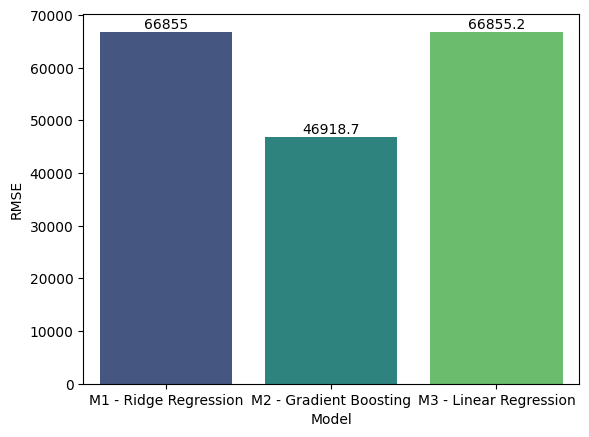

In [26]:
# Creating a bar plot using Seaborn to visualize RMSE values for each model
ax = sns.barplot(data=rmse_score_dataframe, x='Model', y='RMSE', palette='viridis')

# Adding labels to the bars with RMSE values
for i in ax.containers:
    ax.bar_label(i,)

# Displaying the plot


### RMSE Score Comparison - Rationale

- Can clearly see that Gradient Boosting had the smallest RMSE value.
- This was followed in tied 2nd place by both Lineer Regression and Ridge Regression

<strong>Interpretation</strong>
- These results show that both M1 and M2 had predictions that were fair off
- This gives it the ability to focus on the features which contribute most to predicting the target feature over several iterations
- Gradient boost is also more robust against outliers than Ridge and Linear Regression and even though they have been removed, any erroneous values might have negativelty affected the other models


### MAE Score Comparison

In [27]:
# Importing necessary module from scikit-learn
from sklearn.metrics import mean_absolute_error

# Function to return an array of MAE (Mean Absolute Error) for each model on the test set
def return_mae_array(models):
    # Array to store MAE for each model
    mae_array = []

    # Loop through each model in the list
    for model in models:
        # Make predictions on the test set using the current model
        y_test_pred = model.predict(X_test)

        # Calculate the mean absolute error on the test set
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # Append the MAE to the array
        mae_array.append(test_mae)

    # Return the array of MAE values
    return mae_array

In [28]:
# Creating a DataFrame to store MAE values for each model
mae_score_dataframe = pd.DataFrame({
    'MAE': return_mae_array(MODELS),
    'Model': ['M1 - Ridge Regression', 'M2 - Gradient Boosting', 'M3 - Linear Regression']
})

# Displaying the DataFrame
mae_score_dataframe

,MAE,Model
0,49140.147278,M1 - Ridge Regression
1,31469.024428,M2 - Gradient Boosting
2,49140.368234,M3 - Linear Regression


C:\Users\Temp\AppData\Local\Temp\ipykernel_20468\4294483980.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mae_score_dataframe, x='Model', y='MAE', palette='viridis')


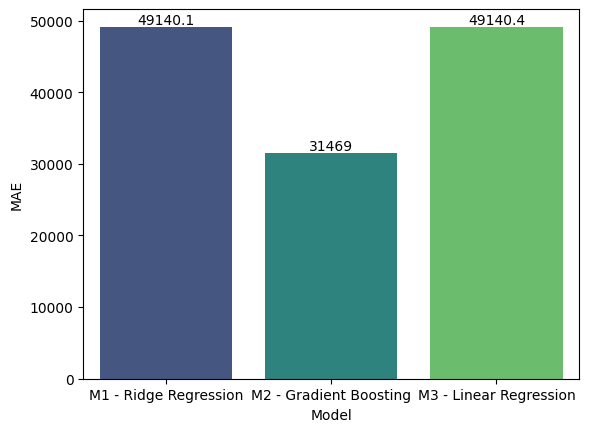

In [29]:
# Creating a bar plot using Seaborn to visualize MAE values for each model
ax = sns.barplot(data=mae_score_dataframe, x='Model', y='MAE', palette='viridis')

# Adding labels to the bars with MAE values
for i in ax.containers:
    ax.bar_label(i,)

# Displaying the plot


### MAE Score Comparison - Rationale
- Can clearly see that Gradient Boosting had the smallest MAE (31.52 s.f) value.
- This was followed in tied 2nd place by both Lineer Regression and Ridge Regression

<strong>Interpretation</strong>
- These results show that both M1 and M2 had predictions that were far off
- This gives it the ability to focus on the features which contribute most to predicting the target feature over several iterations
- Gradient boost is also more robust against outliers than Ridge and Linear Regression and even though they have been removed, any erroneous values might have negativelty affected the other models

## Conclusion

- To conclude, Gradient Boost was the best regression model to pick for this dataset
    - It was robust against outliers and against collinear features 
    - It had the best performance metrics, including an R^2 score of 0.83 (2s.f)
    - The dataset had clues that hinted at Multi-collinearity which is easily handled by Gradient Boost

- Linear Regression and Ridge Regression were also good choices for models but I knew they wouldn't yield the best results.
- Linear Regression's results were most surprising as I was expecting it to perform the worst out of the 3, but it performed very similarly to Ridge Regression
    - This shows the Regularisation Ridge Regresion does didn't change results much meaning there were 'model-specific' factors affecting the performance of the models.

- The metrics I used were comprehensive and gave good insights into the performance of each of the models.
- MAE and RMSE however, yielded very similar values (as they are similar metrics) and so I could have used just 1 to show the average error of each model's predictions

